In [ ]:
!git clone https://github.com/shariarvg/caramba.git

Cloning into 'caramba'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 124 (delta 56), reused 95 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (124/124), 35.75 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [ ]:
%cd caramba

/content/caramba


In [ ]:
!pip3 install -q convokit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -q mamba-ssm causal-conv1d>=1.2.0
!pip install git+https://github.com/huggingface/transformers@main

  Cloning https://github.com/huggingface/transformers (to revision main) to /tmp/pip-req-build-_0w2d5n1
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-_0w2d5n1
  Resolved https://github.com/huggingface/transformers to commit 953196a43dae6a3c474165fba7d215fcbc7b7730
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.52.0.dev0-py3-none-any.whl size=11132583 sha256=82fe7c71090c85f7e38465521b3784061e7c887e13362c49525c48ec482ca9bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-plruvqax/wheels/51/5c/6c/2ea4669c879f41cf3650174af3be8902b058cfaf2cf56bab48
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.50.3
    Uninstalling transformers-4.50.3:
      Successfully uninstalled transformers-4.50.3


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [ ]:
import torch
from torch.utils.data import Dataset
import random

class TokenizedMovieDataset(Dataset):
    """
    A PyTorch Dataset class for processing movie dialogue data.

    This class tokenizes movie dialogue, maps speaker IDs to sequential integers,
    and creates data points for each position in each movie. It returns input tokens,
    labels, speaker masks, and attention masks for model training and evaluation.

    Attributes:
        tokenizer: The tokenizer used to process text
        data: List of dictionaries containing tokenized movie data
        padding: Whether to pad sequences
        max_length: Maximum sequence length
        min_length: Minimum sequence length for a movie to be included
        speaker_to_id: Mapping from speaker names to sequential IDs
        id_to_speaker: Mapping from sequential IDs to speaker names
        index_mapping: List of (movie_idx, position) pairs for data points
    """

    def __init__(self, all_movies, tokenizer, padding=False, max_length=512, min_length=100):
        """
        Initialize the dataset with tokenized movie data.

        Args:
            all_movies (dict): Dictionary containing movie text and speaker IDs
            tokenizer: The tokenizer to use for processing text
            padding (bool, optional): Whether to pad sequences. Defaults to False.
            max_length (int, optional): Maximum sequence length. Defaults to 512.
            min_length (int, optional): Minimum sequence length for a movie. Defaults to 100.
        """
        self.tokenizer = tokenizer
        self.data = []
        self.padding = padding
        self.max_length = max_length
        self.min_length = min_length

        # Create a mapping of unique speaker IDs to integers
        self.speaker_to_id = {}
        self.id_to_speaker = {}
        current_id = 0

        for movie_idx in range(len(all_movies['text'])):
            lines = all_movies['text'][movie_idx]
            speakers = all_movies['speaker_ids'][movie_idx]

            # Build full text and per-character speaker ID list
            full_text = ""
            full_speaker_ids = []

            for line, speaker in zip(lines, speakers):
                full_text += line
                full_speaker_ids.extend([speaker] * len(line))

            encoded = tokenizer(
                    full_text,
                    return_offsets_mapping=True,
                    return_tensors=None,
                    add_special_tokens=False,  # optional, depending on use
                    max_length=max_length,  # Truncate to max_length
                    truncation=True
                )

            input_ids = encoded["input_ids"]
            if len(input_ids) < self.min_length:
                continue
            offsets = encoded["offset_mapping"]

            # Map each token to a speaker ID based on the token's starting char
            token_speaker_ids = []
            # Keep track of speakers we've seen in this movie
            speaker_order = {}
            next_id = 0

            for start, end in offsets:
                if start < len(full_speaker_ids):
                    speaker = full_speaker_ids[start]
                    # Assign sequential IDs as we encounter new speakers
                    if speaker not in speaker_order:
                        speaker_order[speaker] = next_id
                        next_id += 1
                    token_speaker_ids.append(speaker_order[speaker])
                else:
                    # In case offset is beyond the text (shouldn't happen, but safe fallback)
                    token_speaker_ids.append(0)

            # Convert input_ids and token_speaker_ids to tensors
            input_ids = torch.tensor(input_ids, dtype=torch.long)
            token_speaker_ids = torch.tensor(token_speaker_ids, dtype=torch.long)

            self.data.append({
                "input_ids": input_ids,
                "token_speaker_ids": token_speaker_ids
            })

        # Create a mapping from global index to (movie_idx, position)
        self.index_mapping = []
        for movie_idx, movie_data in enumerate(self.data):
            seq_length = len(movie_data["input_ids"])
            # For each movie, create data points for all positions from min_length to seq_length-1
            for position in range(self.min_length - 1, seq_length - 1):
                self.index_mapping.append((movie_idx, position))

        print(f"Created {len(self.index_mapping)} total data points from {len(self.data)} movies")

    def __len__(self):
        """
        Return the total number of data points in the dataset.

        Returns:
            int: The number of data points
        """
        return len(self.index_mapping)

    def getitem_old(self, idx):
        """
        Legacy method to get a movie by index.

        Args:
            idx (int): Index of the movie

        Returns:
            dict: Movie data containing input_ids and token_speaker_ids
        """
        return self.data[idx]

    def getitem_doc_with_position(self, doc_idx, position):
        """
        Get tokens up to a specific position in a document, along with the next token as label
        and a speaker mask indicating which previous tokens share the same speaker as the label.

        Args:
            doc_idx (int): Index of the document in the dataset
            position (int): Number of tokens to include (0-based)

        Returns:
            dict: Contains:
                - input_ids: Tensor of tokens up to position, padded to max_length
                - label: The next token after position
                - speaker_mask: Binary mask indicating which previous tokens share speaker with label
                - attention_mask: Binary mask indicating which tokens are actual content (1) vs padding (0)
        """
        doc = self.data[doc_idx]
        input_ids = doc["input_ids"]
        speaker_ids = doc["token_speaker_ids"]

        # Ensure position is valid
        if position >= len(input_ids) - 1:
            raise ValueError(f"Position {position} is too large for document of length {len(input_ids)}")

        # Get tokens up to position
        context_tokens = input_ids[:position + 1]
        context_speaker_ids = speaker_ids[:position + 1]

        pad_token_id = self.tokenizer.pad_token_id or self.tokenizer.eos_token_id
        # Create attention mask (1 for actual tokens, 0 for padding)
        attention_mask = torch.ones(len(context_tokens), dtype=torch.long)

        # Pad or truncate to max_length (truncate from the left to keep the most recent context)
        if len(context_tokens) > self.max_length:
            context_tokens = context_tokens[-self.max_length:]
            context_speaker_ids = context_speaker_ids[-self.max_length:]
            attention_mask = attention_mask[-self.max_length:]
        elif len(context_tokens) < self.max_length:
            # Pad with zeros (assuming 0 is the padding token)
            padding = torch.full((self.max_length - len(context_tokens),),fill_value=pad_token_id, dtype=torch.long)
            context_tokens = torch.cat([padding, context_tokens])
            # Also pad speaker_ids
            speaker_padding = torch.zeros(self.max_length - len(context_speaker_ids), dtype=torch.long)
            context_speaker_ids = torch.cat([speaker_padding, context_speaker_ids])
            # Pad attention mask with zeros
            attention_padding = torch.zeros(self.max_length - len(attention_mask), dtype=torch.long)
            attention_mask = torch.cat([attention_padding, attention_mask])

        # Get the next token as label
        label = input_ids[position + 1]
        # Get speaker ID of the label token
        label_speaker = speaker_ids[position + 1]
        # Create binary mask for same speaker
        speaker_mask = (context_speaker_ids == label_speaker).float()

        return {
            "input_ids": context_tokens,
            "label": label,
            "speaker_mask": speaker_mask,
            "attention_mask": attention_mask
        }

    def __getitem__(self, idx):
        """
        Main entry point for PyTorch DataLoader.

        Args:
            idx (int or slice): Index or slice of items to retrieve

        Returns:
            dict or list: Data point(s) containing input_ids, label, speaker_mask, and attention_mask
        """
        # Handle slicing
        if isinstance(idx, slice):
            # Create a new dataset with the sliced indices
            sliced_dataset = TokenizedMovieDataset.__new__(TokenizedMovieDataset)
            sliced_dataset.tokenizer = self.tokenizer
            sliced_dataset.data = self.data
            sliced_dataset.padding = self.padding
            sliced_dataset.max_length = self.max_length
            sliced_dataset.min_length = self.min_length
            sliced_dataset.speaker_to_id = self.speaker_to_id
            sliced_dataset.id_to_speaker = self.id_to_speaker

            # Slice the index_mapping
            sliced_dataset.index_mapping = self.index_mapping[idx]

            return sliced_dataset

        # Get the movie index and position from the mapping
        movie_idx, position = self.index_mapping[idx]
        return self.getitem_doc_with_position(movie_idx, position)

class TokenizedMovieDatasetForMaskedLM(TokenizedMovieDataset):
    def __init__(self, all_movies, tokenizer, padding=False, max_length=512, min_length=100):
        super().__init__(all_movies, tokenizer, padding, max_length, min_length)

    def __getitem__(self, idx):
        item = super().__getitem__(idx)
        #modify input_ids
        input_ids = item["input_ids"]
        input_ids = torch.cat([input_ids, torch.tensor([self.tokenizer.mask_token_id])])
        #create new labels
        label = input_ids.clone()
        label[-1] = item['label']
        label[:-1] = -100
        # modify speaker mask
        speaker_mask = item["speaker_mask"]
        speaker_mask = torch.cat([speaker_mask, torch.tensor([1])])
        return {"input_ids": input_ids, "label": label, "speaker_mask":  speaker_mask}

class RandomSubsetDataset(Dataset):
    """
    A dataset wrapper that returns a random subset of another dataset.

    This class is useful for testing and evaluation purposes, allowing you to
    quickly get a random subset of a larger dataset without modifying the original.

    Attributes:
        dataset: The original dataset to sample from
        indices: The indices of the items to include in the subset
    """

    def __init__(self, dataset, size=None, fraction=None, seed=None):
        """
        Initialize the random subset dataset.

        Args:
            dataset: The original dataset to sample from
            size (int, optional): The number of items to include in the subset.
                                If None, fraction is used instead.
            fraction (float, optional): The fraction of the dataset to include.
                                      Used only if size is None.
            seed (int, optional): Random seed for reproducibility.
        """
        if seed is not None:
            random.seed(seed)

        if size is not None:
            self.size = min(size, len(dataset))
        elif fraction is not None:
            self.size = int(len(dataset) * fraction)
        else:
            raise ValueError("Either size or fraction must be provided")

        self.dataset = dataset
        self.indices = random.sample(range(len(dataset)), self.size)

    def __len__(self):
        """
        Return the number of items in the subset.

        Returns:
            int: The number of items in the subset
        """
        return self.size

    def __getitem__(self, idx):
        """
        Get an item from the subset.

        Args:
            idx (int): Index of the item to retrieve

        Returns:
            The item from the original dataset at the randomly selected index
        """
        return self.dataset[self.indices[idx]]

    def get_indices(self):
        """
        Get the indices of the items in the subset.

        Returns:
            list: The indices of the items in the subset
        """
        return self.indices

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Load our SSM for Hidden States and Load Dataset

In [ ]:
model_name = "state-spaces/mamba-370m-hf"

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel
from torch.utils.data import DataLoader
#from dataset import TokenizedMovieDataset, RandomSubsetDataset
from reshape_movies import get_dictionary_of_movies
from inference import load_embedding_model_and_tokenizer, get_dictionary_of_movies
import numpy as np
import os, sys

start_movie_id = 0
end_movie_id = 30

# Load model and tokenizer, doesn't have to be jamba
model, tokenizer = load_embedding_model_and_tokenizer(model_name)
tokenizer.add_tokens(["  "])  # Add double-space as a special token
model.resize_token_embeddings(len(tokenizer))

# Get the movie dataset
print("Loading movie dataset...")
all_movies = get_dictionary_of_movies(N_MOVIES_TO_USE=end_movie_id - start_movie_id, start_movie_id=start_movie_id)  # Start with 10 movies for testing
dataset = TokenizedMovieDataset(all_movies, tokenizer, padding=True, max_length=300, min_length=200)

dataset = RandomSubsetDataset(dataset, size=300000)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/917 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.49G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Loading movie dataset...
No configuration file found at /root/.convokit/config.yml; writing with contents: 
# Default Backend Parameters
db_host: localhost:27017
data_directory: ~/.convokit/saved-corpora
model_directory: ~/.convokit/saved-models
default_backend: mem
Created 3000 total data points from 30 movies


In [ ]:
print(model.device)

cuda:0


Get Mamba (SSM) Hidden States and Labels to train on

In [ ]:
def obtain_mamba_double_hidden_states_and_labels(model, tokenizer, dataset, batch_size=4):
    """
    Obtain both speaker-specific and general hidden states, along with labels.

    This function extracts two sets of hidden states for each item in the dataset:
    1. Speaker-specific hidden states using the speaker mask
    2. General hidden states using the attention mask

    It also returns the labels for each item.

    Args:
        model: The model to extract hidden states from
        tokenizer: The tokenizer for encoding/decoding text
        dataset: The dataset to process
        batch_size (int, optional): Batch size for processing. Defaults to 4.

    Returns:
        tuple: (hidden_states, labels) - numpy arrays of hidden states and labels
               hidden_states has shape (N, 2D) where N is the number of items and D is the hidden dimension
               labels has shape (N,) where N is the number of items
    """
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()

    all_hidden_states = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device=model.device)
            #print(input_ids.shape)
            labels = batch['label'].to(device=model.device)
            #print(f'Tokenized Labels: {labels}')
            #print(f'Labels: {tokenizer.decode(labels)}')
            speaker_mask = batch['speaker_mask'].to(device=model.device)
            speaker_mask = torch.zeros_like(speaker_mask)
            attention_mask = batch['attention_mask'].to(device=model.device)

            whole_input_ids = input_ids * attention_mask
            speaker_input_ids = input_ids * speaker_mask
            speaker_input_ids = speaker_input_ids.to(dtype=torch.int64)

            #print(whole_input_ids.shape, whole_input_ids.dtype)
            #print(speaker_input_ids.shape, speaker_input_ids.dtype)

            # Use attention mask for general hidden states
            hidden_states_general = model(whole_input_ids, output_hidden_states=True).hidden_states[-1]
            hidden_states_speaker = model(speaker_input_ids, output_hidden_states=True).hidden_states[-1]

            # Concatenate along last dimension to get (B,L,2D)
            hidden_states_concat = torch.cat([hidden_states_speaker, hidden_states_general], dim=-1)

            # Mean pool across sequence length dimension to get (B,2D)
            hidden_states_concat = hidden_states_concat.mean(dim=1)

            all_hidden_states.append(hidden_states_concat.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    return np.concatenate(all_hidden_states, axis=0), np.concatenate(all_labels, axis=0)

In [ ]:
print("Obtaining hidden states...")
hidden_states, labels = obtain_mamba_double_hidden_states_and_labels(model, tokenizer, dataset)

Obtaining hidden states...


In [ ]:
print("Saving hidden states...")
print(f'Hidden_states shape: {hidden_states.shape}')
print(f'Labels shape: {labels.shape}')
np.save(f'hidden_states.npy', hidden_states)
np.save(f'labels.npy', labels)

Saving hidden states...
Hidden_states shape: (3000, 2048)
Labels shape: (3000,)


In [ ]:
DOUBLE_WHITESPACE_TOKEN = 209

Train on Hidden State of Mamba

(3000, 2048)
(3000,)
float32
int64
Training with gradient descent...
Epoch [1/300], Loss: 9.4616, Accuracy: 4.50%
Epoch [2/300], Loss: 6.6564, Accuracy: 4.10%
Epoch [3/300], Loss: 6.5595, Accuracy: 3.37%
Epoch [4/300], Loss: 6.4782, Accuracy: 2.57%
Epoch [5/300], Loss: 6.4898, Accuracy: 2.53%
Epoch [6/300], Loss: 6.4231, Accuracy: 2.87%
Epoch [7/300], Loss: 6.3816, Accuracy: 2.77%
Epoch [8/300], Loss: 6.3331, Accuracy: 2.00%
Epoch [9/300], Loss: 6.4071, Accuracy: 3.10%
Epoch [10/300], Loss: 6.3388, Accuracy: 2.87%
Epoch [11/300], Loss: 6.3212, Accuracy: 2.30%
Epoch [12/300], Loss: 6.3873, Accuracy: 2.40%
Epoch [13/300], Loss: 6.3234, Accuracy: 2.37%
Epoch [14/300], Loss: 6.2872, Accuracy: 2.23%
Epoch [15/300], Loss: 6.2739, Accuracy: 2.37%
Epoch [16/300], Loss: 6.2979, Accuracy: 2.37%
Epoch [17/300], Loss: 6.2857, Accuracy: 2.53%
Epoch [18/300], Loss: 6.2834, Accuracy: 2.63%
Epoch [19/300], Loss: 6.2236, Accuracy: 2.50%
Epoch [20/300], Loss: 6.2526, Accuracy: 2.17%
Epoch [21/300], Loss

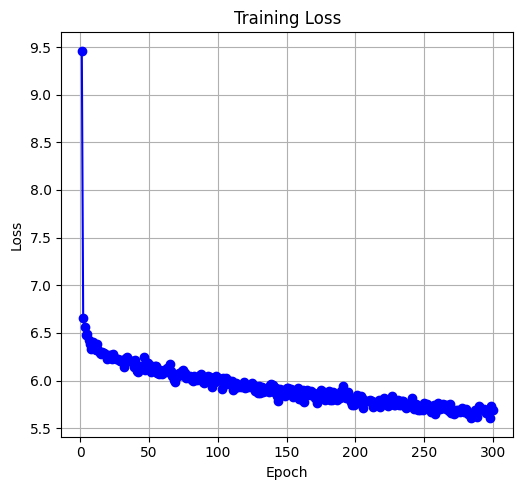

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LogisticRegression
import numpy as np
from dataset import TokenizedMovieDataset
from reshape_movies import get_dictionary_of_movies
from inference import load_embedding_model_and_tokenizer, obtain_double_hidden_states_and_labels
import sys

class TokenPredictor(nn.Module):
    """
    A simple neural network for predicting the next token.

    This model takes hidden states as input and predicts the next token in the sequence.
    It consists of a single linear layer that maps from the hidden state dimension
    to the vocabulary size.

    Attributes:
        linear (nn.Linear): Linear layer for token prediction
    """

    def __init__(self, input_dim, vocab_size):
        """
        Initialize the token predictor.

        Args:
            input_dim (int): Dimension of the input hidden states
            vocab_size (int): Size of the vocabulary (number of possible tokens)
        """
        super().__init__()
        self.linear = nn.Linear(input_dim, vocab_size)

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim)

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, vocab_size)
        """
        return self.linear(x)


def train_gradient_descent(hidden_states_pooled, labels, vocab_size, n_epochs=300, batch_size=16):
    """
    Train a neural network using gradient descent.

    This function trains a TokenPredictor model using the Adam optimizer
    and cross-entropy loss. It prints the loss and accuracy for each epoch.

    Args:
        hidden_states_pooled (numpy.ndarray): Hidden states with shape (N, D)
        labels (numpy.ndarray): Labels with shape (N,)
        vocab_size (int): Size of the vocabulary
        n_epochs (int, optional): Number of training epochs. Defaults to 10.
        batch_size (int, optional): Batch size for training. Defaults to 16.

    Returns:
        TokenPredictor: The trained model
    """
    print("Training with gradient descent...")

    # Initialize model and move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert numpy arrays to PyTorch tensors
    hidden_states_tensor = torch.tensor(hidden_states_pooled)
    labels_tensor = torch.tensor(labels)

    model = TokenPredictor(hidden_states_tensor.shape[-1], vocab_size).to(device)

    # Create data loader
    dataset = torch.utils.data.TensorDataset(hidden_states_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses = []
    # Training loop
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_hidden, batch_labels in dataloader:
            batch_hidden = batch_hidden.to(device).to(dtype=torch.float32)
            batch_labels = batch_labels.to(device).to(dtype=torch.int64)

            optimizer.zero_grad()
            outputs = model(batch_hidden)

            invalid_labels = batch_labels >= vocab_size
            """
            Double white space tokens cause problems to some tokenizers. Thus, invalid tokens are replaced with DOUBLE_WHITESPACE_TOKEN.
            """
            if invalid_labels.any():
                #print("Warning: Found invalid label values. Clipping to DOUBLE_WHITESPACE_TOKEN.")
                batch_labels[invalid_labels] = DOUBLE_WHITESPACE_TOKEN

            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

        mean_accuracy = 100 * correct / total
        avg_train_loss = total_loss / len(dataloader)
        train_losses.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {mean_accuracy:.2f}%')

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_epochs+1), train_losses, 'b-o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model

def train_logistic_regression(hidden_states, labels, vocab_size):
    """
    Train a logistic regression model.

    This function trains a multinomial logistic regression model using scikit-learn.
    It prints the accuracy of the model on the training data.

    Args:
        hidden_states (numpy.ndarray): Hidden states with shape (N, D)
        labels (numpy.ndarray): Labels with shape (N,)
        vocab_size (int): Size of the vocabulary

    Returns:
        LogisticRegression: The trained model
    """
    print("Training with logistic regression...")

    # Mean pool across sequence length dimension
    X = hidden_states  # Shape: (batch_size, 2D)
    y = labels#.numpy()

    # Train logistic regression
    model = LogisticRegression(multi_class='multinomial', max_iter=100)
    model.fit(X, y)

    # Calculate accuracy
    accuracy = model.score(X, y) * 100
    print(f'Logistic Regression Accuracy: {accuracy:.2f}%')

    return model


"""
Main function to train token predictors.

This function:
1. Loads hidden states and labels
2. Trains a neural network using gradient descent
3. Trains a logistic regression model
4. Saves both models

Command line arguments:
    sys.argv[1]: model_name - The name of the model used to generate the hidden states
"""
model_name = "state-spaces/mamba-370m-hf"
# Load model and tokenizer
_, tokenizer = load_embedding_model_and_tokenizer(model_name)
# Prepare data
hidden_states = np.load(f'hidden_states.npy')
labels = np.load(f'labels.npy')

print(hidden_states.shape)
print(labels.shape)
print(hidden_states.dtype)
print(labels.dtype)

# Train models
vocab_size = tokenizer.vocab_size

# Train with gradient descent
gd_model = train_gradient_descent(hidden_states, labels, vocab_size)

# Train with logistic regression
#lr_model = train_logistic_regression(hidden_states, labels, vocab_size)

# Save models
torch.save(gd_model.state_dict(), f'mamba_hidden_state.pt')
#np.save(f'../token_predictor_mamba_lr.npy', lr_model)

Test Perplexity Score and Semantics Score of Our Model

In [ ]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 1.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

In [ ]:
import torch
import sys
import numpy as np
#from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM
from dataset import TokenizedMovieDataset, RandomSubsetDataset
from reshape_movies import get_dictionary_of_movies
from inference import load_embedding_model_and_tokenizer
from train_predictor import TokenPredictor

def calculate_perplexity(logits, labels):
    """
    Calculate perplexity from logits and labels.

    Perplexity is a measure of how well a probability model predicts a sample.
    It is defined as exp(cross_entropy_loss).

    Args:
        logits (torch.Tensor): Model output logits with shape (N, vocab_size)
        labels (torch.Tensor): True labels with shape (N,)

    Returns:
        float: The calculated perplexity
    """
    # Convert logits to probabilities
    probs = torch.softmax(logits, dim=-1)

    # Get probability of the actual labels
    label_probs = probs[torch.arange(len(labels)), labels]

    # Calculate cross entropy loss
    loss = -torch.mean(torch.log(label_probs + 1e-10))

    # Perplexity is exp(loss)
    perplexity = torch.exp(loss)

    return perplexity.item()

def calculate_perplexity_numpy(probs, labels):
    """
    Calculate perplexity from probabilities and labels using NumPy.

    This function is used for sklearn models that return probabilities directly.

    Args:
        probs (numpy.ndarray): Model output probabilities with shape (N, vocab_size)
        labels (numpy.ndarray): Labels with shape (N,)

    Returns:
        float: The calculated perplexity
    """
    # Get probability of the actual labels
    label_probs = probs[np.arange(len(labels)), labels]

    # Calculate cross entropy loss
    loss = -np.mean(np.log(label_probs + 1e-10))  # Add small epsilon to avoid log(0)

    # Perplexity is exp(loss)
    perplexity = np.exp(loss)

    return perplexity



def calculate_semantic_score(logits, labels, tokenizer, nlp):
    """
    Calculate semantic similarity between predicted tokens and ground truth tokens
    using spaCy word embeddings.

    Args:
        logits: Model output logits (shape: batch_size, seq_len, vocab_size)
        labels: Ground truth token IDs (shape: batch_size, seq_len)
        tokenizer: Tokenizer for decoding tokens
        nlp: Loaded spaCy model with word vectors

    Returns:
        float: Average cosine similarity between predicted and true words
    """
    import torch
    import numpy as np

    # Convert logits to predicted tokens
    pred_tokens = torch.argmax(logits, dim=-1)

    similarities = []

    # Iterate through each sequence in the batch
    for p_token, t_token in zip(pred_tokens.cpu().numpy(), labels.cpu().numpy()):
        try:
            # Decode tokens to words
            p_word = tokenizer.decode(p_token).strip().lower()
            t_word = tokenizer.decode(t_token).strip().lower()

            # Skip special tokens and empty strings
            if (not p_word or not t_word or
                p_word in tokenizer.all_special_tokens or
                t_word in tokenizer.all_special_tokens):
                continue

            # Process words with spaCy
            p_doc = nlp(p_word)
            t_doc = nlp(t_word)

            # Check for valid vectors
            if len(p_doc) == 0 or len(t_doc) == 0:
                continue

            p_token_spacy = p_doc[0]
            t_token_spacy = t_doc[0]

            if not p_token_spacy.has_vector or not t_token_spacy.has_vector:
                continue

            # Calculate similarity
            similarity = p_token_spacy.similarity(t_token_spacy)
            similarities.append(similarity)

        except Exception as e:
            print(f"Error processing words: {p_word} vs {t_word} - {str(e)}")
            continue

    return np.mean(similarities) if similarities else 0.0

def get_hidden_states_and_labels(model, tokenizer, dataset, batch_size=4):
    """
    Get hidden states and labels from the dataset.
    """
    hidden_states, labels = obtain_mamba_double_hidden_states_and_labels(model, tokenizer, dataset, batch_size=batch_size)
    hidden_states = torch.tensor(hidden_states, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)
    return hidden_states, labels

def evaluate_perplexity(predictor, hidden_states, labels, batch_size=4):
    """
    Evaluate perplexity on the dataset.

    This function:
    1. Obtains hidden states and labels from the dataset
    2. Uses the predictor to generate logits
    3. Calculates perplexity from the logits and labels

    Args:
        model: The embedding model
        tokenizer: The tokenizer for encoding/decoding text
        predictor: The trained token predictor
        dataset: The dataset to evaluate on
        batch_size (int, optional): Batch size for processing. Defaults to 4.

    Returns:
        float: The calculated perplexity
    """
    print("Loading NLP...")
    nlp = spacy.load('en_core_web_lg')
    print("Computing logits and calculating perplexity...")
    with torch.no_grad():
        logits = predictor(hidden_states)
        perplexity = calculate_perplexity(logits, labels)
        semantic_score = calculate_semantic_score(logits, labels, tokenizer, nlp)

    return perplexity, semantic_score

def evaluate_lr_perplexity(lr_model, hidden_states, labels):
    """
    Evaluate perplexity on the dataset using a logistic regression model.

    This function:
    1. Uses the logistic regression model to predict probabilities
    2. Calculates perplexity from the probabilities and labels

    Args:
        lr_model: The trained logistic regression model
        hidden_states (torch.Tensor): Hidden states with shape (N, D)
        labels (torch.Tensor): Labels with shape (N,)

    Returns:
        float: The calculated perplexity
    """
    print("Computing probabilities and calculating perplexity...")

    # Convert to numpy for sklearn
    hidden_states_np = hidden_states.cpu().numpy()
    labels_np = labels.cpu().numpy()

    # Get the number of classes in the logistic regression model
    n_classes = lr_model.classes_.shape[0]
    print(f"Logistic regression model has {n_classes} classes")

    # Filter out labels that are outside the model's vocabulary range
    valid_indices = labels_np < n_classes
    if not np.all(valid_indices):
        print(f"Warning: {np.sum(~valid_indices)} labels are outside the model's vocabulary range")
        print(f"These labels will be excluded from perplexity calculation")
        hidden_states_np = hidden_states_np[valid_indices]
        labels_np = labels_np[valid_indices]

        if len(labels_np) == 0:
            print("Error: No valid labels remain after filtering")
            return float('inf')

    # Get probabilities from the model
    probs = lr_model.predict_proba(hidden_states_np)

    # Calculate perplexity
    perplexity = calculate_perplexity_numpy(probs, labels_np)

    return perplexity

def evaluate_gpt2_perplexity(model, tokenizer, dataset, batch_size=1):
    """
    Evaluate perplexity on the dataset using a GPT-2 model.

    This function:
    1. Processes the dataset to get input sequences and labels
    2. Passes the input sequences through the GPT-2 model
    3. Extracts the logits from the model output
    4. Calculates perplexity from the logits and labels

    Args:
        model: The GPT-2 model
        tokenizer: The tokenizer for encoding/decoding text
        dataset: The dataset to evaluate on
        batch_size (int, optional): Batch size for processing. Defaults to 1.

    Returns:
        float: The calculated perplexity
    """
    from torch.utils.data import DataLoader

    # Create a random subset of the dataset for evaluation
    # This helps reduce memory usage and computation time
    subset_size = min(100, len(dataset))  # Use at most 100 items or the full dataset if smaller
    subset_dataset = RandomSubsetDataset(dataset, size=subset_size, seed=42)  # Fixed seed for reproducibility

    # Create a dataloader for the dataset
    dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=False)

    # Move model to the appropriate device
    device = next(model.parameters()).device
    model.eval()

    # Enable gradient checkpointing to save memory
    if hasattr(model, "gradient_checkpointing_enable"):
        model.gradient_checkpointing_enable()

    all_logits = []
    all_labels = []

    print("Computing logits and calculating perplexity...")
    with torch.no_grad():
        for batch in dataloader:
            # Get input IDs and attention mask
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            #print("Input ids: ",input_ids.shape)

            # Get model outputs
            outputs = model(input_ids, attention_mask=attention_mask)

            # Extract logits from the output
            # For GPT-2, logits are in outputs.logits
            # We need to get the logits for the next token prediction
            # Shape: (batch_size, seq_len, vocab_size)
            logits = outputs.logits

            # Get the logits for the position of each label
            # We need to shift the input_ids to get the correct positions
            # For each sequence, we want the logits at position i-1 to predict token at position i
            shifted_logits = logits[:, :-1, :]
            shifted_labels = input_ids[:, 1:]

            # Store the logits and labels
            all_logits.append(shifted_logits.reshape(-1, shifted_logits.size(-1)))
            all_labels.append(shifted_labels.reshape(-1))

    # Concatenate all logits and labels
    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Calculate perplexity
    perplexity = calculate_perplexity(all_logits, all_labels)

    return perplexity


def evaluate_mamba_perplexity(model, tokenizer, dataset, batch_size=1):
    """
    Evaluate perplexity on the dataset using a Mamba model.

    This function:
    1. Processes the dataset to get input sequences
    2. Passes the input sequences through the Mamba model
    3. Extracts the logits from the model output
    4. Calculates perplexity from the logits and shifted labels

    Args:
        model: The Mamba model
        tokenizer: The tokenizer for encoding/decoding text
        dataset: The dataset to evaluate on
        batch_size (int, optional): Batch size for processing. Defaults to 1.

    Returns:
        float: The calculated perplexity
    """
    from torch.utils.data import DataLoader
    import torch

    # Create a random subset of the dataset for evaluation
    subset_size = min(100, len(dataset))
    subset_dataset = RandomSubsetDataset(dataset, size=subset_size, seed=42)

    dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=False)

    device = next(model.parameters()).device
    model.eval()

    # Gradient checkpointing (if supported)
    if hasattr(model, "gradient_checkpointing_enable"):
        model.gradient_checkpointing_enable()

    all_logits = []
    all_labels = []

    print("Computing logits and calculating perplexity...")
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)

            # Forward pass through Mamba (no attention_mask needed)
            outputs = model(input_ids)
            logits = outputs.logits  # Shape: (batch_size, seq_len, vocab_size)

            # Shift logits and labels for next token prediction
            shifted_logits = logits[:, :-1, :]
            shifted_labels = input_ids[:, 1:]

            all_logits.append(shifted_logits.reshape(-1, shifted_logits.size(-1)))
            all_labels.append(shifted_labels.reshape(-1))

    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    perplexity = calculate_perplexity(all_logits, all_labels)

    return perplexity

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel
from torch.utils.data import DataLoader
#from dataset import TokenizedMovieDataset, RandomSubsetDataset
from reshape_movies import get_dictionary_of_movies
from inference import load_embedding_model_and_tokenizer, get_dictionary_of_movies
import numpy as np
import os, sys

Our Model Perplexity against Test

In [ ]:
TEST_SIZE = 50

In [ ]:
# Load models
print("Loading models...")
#model, tokenizer = load_embedding_model_and_tokenizer(model_name)


# Load Eval Dataset
print("Loading evaluation dataset...")
start_movie_id = 30
end_movie_id = 40
all_movies = get_dictionary_of_movies(N_MOVIES_TO_USE=end_movie_id - start_movie_id, start_movie_id=start_movie_id)
dataset = TokenizedMovieDataset(all_movies, tokenizer, padding=True, max_length=300, min_length=200)
del all_movies
# Take a random subset of TEST_SIZE samples from the dataset
indices = torch.randperm(len(dataset))[:TEST_SIZE]
dataset = torch.utils.data.Subset(dataset, indices)

# Load predictor (make sure to load state dict correctly)
print("Loading predictor...")
#predictor = TokenPredictor(input_dim=1536, vocab_size=tokenizer.vocab_size).to('cuda')  # 1536 = 2 * 768 (GPT-2 hidden size).t
#predictor.load_state_dict(torch.load(f"../token_predictor_{model_name}_gd.pt"))

predictor = gd_model
predictor.eval()

"""
# Load logistic regression model
print("Loading logistic regression model...")
#lr_model = np.load(f"../token_predictor_{model_name}_lr.npy", allow_pickle=True).item()

lr_model = lr_model
"""
## Get hidden states and labels
print("Getting hidden states and labels...")
hidden_states, labels = get_hidden_states_and_labels(model, tokenizer, dataset)
hidden_states = hidden_states.to('cuda')
labels = labels.to('cuda')

Loading models...
Loading evaluation dataset...
Created 1000 total data points from 10 movies
Loading predictor...
Getting hidden states and labels...


In [ ]:
# Evaluate perplexity of GD model
print("Evaluating perplexity...")
perplexity, semantic_score = evaluate_perplexity(predictor, hidden_states, labels)

print(f"Perplexity on held-out data, using token predictor (GD): {perplexity:.4f}")
print(f"Semantic Similarity Score using token predictor (GD): {semantic_score:.4f}")

# Evaluate perplexity of LR model
print("Evaluating perplexity of LR model...")
lr_perplexity = evaluate_lr_perplexity(lr_model, hidden_states, labels)

print(f"Perplexity on held-out data, using token predictor (LR): {lr_perplexity:.4f}")

GPT-2 Perplexity against Test

In [ ]:
# Evaluate perplexity using basic model
print("Loading GPT-2 model for direct perplexity evaluation...")
gpt2_model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Set padding token if not set
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
    gpt2_model.config.pad_token_id = gpt2_model.config.eos_token_id

gpt2_perplexity = evaluate_gpt2_perplexity(gpt2_model, gpt2_tokenizer, dataset)

print(f"Perplexity on held-out data, using GPT-2 model: {gpt2_perplexity:.4f}")

Loading GPT-2 model for direct perplexity evaluation...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Computing logits and calculating perplexity...
Perplexity on held-out data, using GPT-2 model: 222.0044


Mamba Perplexity against Test

In [ ]:
# Evaluate perplexity using basic model
print("Loading GPT-2 model for direct perplexity evaluation...")
mamba_model = AutoModelForCausalLM.from_pretrained("state-spaces/mamba-370m-hf").to(device)
mamba_tokenizer = AutoTokenizer.from_pretrained("state-spaces/mamba-370m-hf")

# Set padding token if not set
if mamba_tokenizer.pad_token is None:
    mamba_tokenizer.pad_token = mamba_tokenizer.eos_token
    mamba_model.config.pad_token_id = mamba_model.config.eos_token_id

gpt2_perplexity = evaluate_mamba_perplexity(mamba_model, mamba_tokenizer, dataset)

print(f"Perplexity on held-out data, using Mamba base model: {gpt2_perplexity:.4f}")

Loading GPT-2 model for direct perplexity evaluation...


config.json:   0%|          | 0.00/917 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.49G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Computing logits and calculating perplexity...
Perplexity on held-out data, using Mamba base model: 105.5779


GENERATION ON TEST DATASET

In [ ]:
GEN_SIZE = 2
start_movie_id = 30
end_movie_id = 40
all_movies = get_dictionary_of_movies(N_MOVIES_TO_USE=end_movie_id - start_movie_id, start_movie_id=start_movie_id)
dataset = TokenizedMovieDataset(all_movies, tokenizer, padding=True, max_length=300, min_length=200)
del all_movies
# Take a random subset of GEN_SIZE samples from the dataset
indices = torch.randperm(len(dataset))[:GEN_SIZE]
dataset = torch.utils.data.Subset(dataset, indices)

Created 1000 total data points from 10 movies


In [ ]:
hidden_states, labels = get_hidden_states_and_labels(model, tokenizer, dataset)
hidden_states = hidden_states.to('cuda')
labels = labels.to('cuda')

In [ ]:
#MoBAMBA Implementation in the future!